# Adversarial Attacks on Pneumonia Detection Model
The goal of adversarial attacks is to "break" or "trick" classifiers by introducing some perturbation to the input. Ideally, this perturbation should be barely perceptible by a person, keeping the original image mostly intact, yet able to deceive a model into classifying it incorrectly. These attacks often make use of the discontinuity involved in deep neural networks, allowing perturbations to "push" data points across decision boundaries. 

The attacks tackled here are examples of white box attacks, adversarial attacks that require one to have access to the model itself as it is involved in the computation of the perturbations. Two particular attacks are implemented and expounded upon in this notebook, a particular example of a Universal Adversarial Perturbation (UAP) and the Fast Gradient Sign Method (FGSM).

We start off by first importing some libraries, declaring paths to our data, settings seeds and initialising the device we want to perform computations on. Note that this notebook makes use of data and a model we have trained that can be downloaded here: https://qmulprod-my.sharepoint.com/:u:/g/personal/ah19432_qmul_ac_uk/EVryOQTgoCdOi3tPAMspduABgz6XZj_1LTacKJrZQC_qww?e=mAwghr.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as lg
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import os
import copy
import random
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm, tqdm_notebook
import scipy
from torchsummary import summary
import pandas as pd
import seaborn as sns

#Path to the training set
training_set_path = os.path.join(os.getcwd(), "data_224_224_big_val_flip", "train")

#Path to the test set 
test_set_path = os.path.join(os.getcwd(), "data_224_224_big_val_flip", "test")

#If there is no CUDA enabled GPU available, use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#Setting the seed for random number generation
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
random.seed(0)

While there are multiple ways to save and load pytorch models, we make use of state dictionaries here. Because of this, we require the class definition in the same notebook. Below is just a copy of the model class definition and a helper function for min-max normalising image tensors.

In [2]:
class Net(nn.Module):
    """
    Neural network class that the model is based on (see description of architecture above). 
    """
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1_1 = nn.Conv2d(3,64,5,stride=1,padding=2)
        self.conv2_1 = nn.Conv2d(64,128,5,stride=1,padding=2)
        self.conv3_1 = nn.Conv2d(128,256,5,stride=1,padding=2)
        self.conv4_1 = nn.Conv2d(256,512,5,stride=1,padding=2)
        self.pool = nn.MaxPool2d(2,2)
        self.big_pool = nn.MaxPool2d(4,4)
        self.fc1 = nn.Linear(7*7*512, 2048)
        self.fc2 = nn.Linear(2048,2048)
        self.fc3 = nn.Linear(2048,2)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x):
        """
        Forward pass function for the neural network 
        """
        #1st Convolutional Layer
        #Input dimension: 3 x 224 x 224
        #Output dimension: 64 x 112 x 112 
        x = self.conv1_1(x)
        x = self.pool(F.relu(x))
        #2nd Convolutional Layer
        #Input dimension: 64 x 112 x 112 
        #Output dimension: 128 x 64 x 64
        x = self.conv2_1(x)
        x = self.pool(F.relu(x))
        #3rd Convolutional Layer
        #Input dimension: 128 x 56 x 56
        #Output dimension: 256 x 28 x 28 
        x = self.conv3_1(x)
        x = self.pool(F.relu(x))
        #4th Convolutional Layer
        #Input dimension: 256 x 28 x 28 
        #Output dimension: 512 x 7 x 7
        x = self.conv4_1(x)
        x = self.big_pool(F.relu(x))
        #Stretching out the image matrix into a vector 
        x = x.view(-1, 7*7*512)
        #Adding 10% dropout 
        x = self.dropout(x)
        #1st fully connected layer with Relu Activation
        #Input dimension: 25088
        #Output dimension: 2048
        x = F.relu(self.fc1(x))
        #Adding 10% dropout 
        x = self.dropout(x)
        #2nd fully connected layer with Relu Activation
        #Input dimension: 2048
        #Output dimension: 2048
        x = F.relu(self.fc2(x))
        #Adding 10% dropout 
        x = self.dropout(x)
        #3rd fully connected layer outputing classification outcomes
        #Input dimension: 2048
        #Output dimension: 2
        x = self.fc3(x)
        return x
    
def normalise_image_tensor(image):
    """
    Min-max normalises an input tensor to allow for visualisation
    
    @param
    image: torch tensor representing an image
    
    @return
    normalised version of the input image 
    """
    minimum = image.min().item()
    maximum = image.max().item()
    return (image-minimum)/(maximum-minimum)

We then create an instance of this class and load the state dictionary from a file. Afterward, the model is set to evaluation mode as there will be no further training of the model itself. Since the model makes use of dropout in the fully connected layers, evaluation mode allows us to ensure that model output is consistent across runs.

In [3]:
model_name = "model_epoch16.pth"
model = Net()
model.load_state_dict(torch.load(model_name))
model.to(device)
model.eval()

Net(
  (conv1_1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_1): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3_1): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4_1): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (big_pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

## I. Universal Adversarial Perturbation
UAP is a form of attack that seeks to find a perturbation that when applied to a data set, maximises the empirical loss. This means that it is independent of individual input. In other words, rather than tailor fitting a perturbation to each input image, it finds a single one to be applied across the data set (hence the "universal" descriptor in its name). While there could be a variety of ways of finding this perturbation, we use here the following formulation from the lecture notes. 
$$\hat{\delta} = \arg\max_{\delta \in \mathbb{R}^n} \left\{\frac{1}{s} \sum_{i=1}^{s} \mathscr{l}_i\left(f_w(x_i+\delta),y_i \right) \ \text{subject to} \ \|\delta\|_\infty \leq \varepsilon \right\} $$

This optimisation problem may then be solved using projected gradient ascent. Below is an application of this method to the specific case of a neural network trained to classify chest X-ray images into PNEUMONIA or NORMAL with data from [1]. We begin by loading the data in using torchvision, first creating an ImageFolder object designating the test set as the data we want to work with.

In [4]:
data_folder = torchvision.datasets.ImageFolder(root=test_set_path,transform=transforms.Compose([transforms.ToTensor()]))

We create two DataLoader objects below. The first, data_loader, has a batch_size of 16 and will be used for the
implementation of projected gradient ascent in "training" the perturbation. The attack_loader has a batch_size of 1 and will be applied in testing the perturbation and recording results so that the impact of the attack on model accuracy can be assessed. 

In [5]:
data_loader = torch.utils.data.DataLoader(data_folder,batch_size=16)
attack_loader = torch.utils.data.DataLoader(data_folder,batch_size=1)

Now that the structure for data loading has been created, we declare some hyperparameters that will be used during the gradient ascent.

In [6]:
#Learning rate (selected through simple trial-and-error)
lr=3
#Number of epochs (selected through trial-and-error)
epochs=3
#Values of epsilon to run the optimisation for. 
epsilon_vals = [0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20]

#Dimensions for data
xi_size=iter(data_loader).next()[0].size()[1:4]

Below then is the main implementation of the Universal Adversarial Perturbation making use of a projected gradient ascent. 

In [7]:
def universal_adversarial_perturbation(lr, epochs, epsilon_vals, xi_size, data_loader, attack_loader, model):
    """
    Runs the universal adversarial perturbation attack across a range of epsilon values using a stochastic gradient ascent 
    to maximise the loss caused by the perturbation 
    
    @param
    lr: learning rate used for the gradient ascent
    epochs: number of epochs for training
    epsilon_vals: list of valeus of epsilon to run the attack for
    xi_size: dimensions of the input data
    data_loader: torch DataLoader for iterating through images during training
    attack_loader: torch DataLoader for applying the perturbation one-by-one and capturing of results
    model: model to be attacked 
    
    @return
    accuracies: list of dictionaries, each element having a key "epsilon" containing the epsilon value and "epoch x" 
                containing the model accuracy after the perturbation was trained on the xth epoch
    pert_matrices: list of dictionaries, each containing an epsilon value and the perturbation for each "epoch x"
    
    """
    
    #Create lists that will be the output of this function
    pert_matrices = []
    accuracies = []
    
    #Run the algorithm for each value of epsilon 
    for epsilon in tqdm(epsilon_vals):
        predictions = [] 
        
        #Initialise a perturbation, here all values tarting at 0.01
        pert_mat=(torch.ones(xi_size)*0.01).to(device)
        pert=Variable(pert_mat,requires_grad=True)
        
        #We make use of cross-entropy loss here
        criterion = nn.CrossEntropyLoss()
        
        #Dictionaries to store the results of the attack as we go through the epochs
        builder = {"epsilon": epsilon}
        pert_builder = {"epsilon": epsilon} 
        
        #For each epoch 
        for i in range(epochs):
            total = 0
            correct = 0
            total_loss=0
            #We run through the data_loader, iterating through each batch of images to optimise the perturbation 
            for batch_idx, (data, labels) in enumerate(data_loader):
                rng_state = torch.get_rng_state()
                
                #Move data to the GPU if available 
                inputs = data.to(device)
                labels = labels.to(device)
                #Adding the noises to the original data 
                input_pert=pert+inputs

                #Model ooutput on perturbed input
                output_pert=model(input_pert)
                loss=criterion(output_pert,labels)
                loss.backward()
                
                #Perform Projected Gradient Descent Step
                total_loss+=loss
                with torch.no_grad():
                    pert=pert+lr*pert.grad

                    #Since we are using the infinity norm, if any value exceeds positive or negative epsilon, 
                    #set it back to positive or negative epsilon
                    pert[pert>epsilon]=epsilon
                    pert[pert<-epsilon]=-epsilon  

                pert.requires_grad=True
                torch.set_rng_state(rng_state)
                
                #Compute average loss and add to the total 
                avg_loss=total_loss/total
                total += labels.size(0)
                
            #At this point, we have finished training on the current epoch. We then observe the impact
            #of the attack on the model accuracy so far. We go through the data again this time 
            #using the attack_loader (which is assumed to have batch_size=1)
            for batch_idx, (data, labels) in enumerate(attack_loader):
                rng_state = torch.get_rng_state()
                inputs = data.to(device)
                labels = labels.to(device)

                with torch.no_grad():
                    #Perform an initial prediction of unperturbed image
                    output = model(inputs)
                    _, initial_prediction = torch.max(output.data, 1)
                    
                    #No use attacking if initial prediction was wrong
                    if initial_prediction.item() != labels.item():
                        continue
                    
                    #Compute the perturbed image and run it through the model again 
                    perturbed_input = pert+inputs
                    perturbed_output = model(perturbed_input)
                    _,final_prediction = torch.max(perturbed_output.data, 1)
                    predictions.append(final_prediction.item())
                    
                    #Compute the number of correct predictions after perturbation 
                    if final_prediction.item() == labels.item():
                        correct += 1
            #Accuracy after the attack 
            accuracy = correct/total
            #We store the results of the attack for the current epoch
            builder["epoch " + str(i)] = accuracy  
            pert_builder["epoch " + str(i)] = pert
            
        #Store all the results that will be returned 
        pert_matrices.append(pert_builder)
        accuracies.append(builder)
    return accuracies, pert_matrices

We then run the algorithm for a range of epsilon values to observe how the model accuracy changes as we increase the value of epsilon. 

In [8]:
accuracies, pert_matrices = universal_adversarial_perturbation(lr, epochs, epsilon_vals, xi_size, data_loader, attack_loader, model)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [12:26<00:00, 67.86s/it]


The table below presents the results for UAP across a range of epsilon values and epochs.

In [9]:
df_acc = pd.DataFrame(accuracies)
df_acc

,epsilon,epoch 0,epoch 1,epoch 2
0,0.00,0.855769,0.855769,0.855769
1,0.02,0.822115,0.812500,0.817308
2,0.04,0.674679,0.644231,0.652244
3,0.06,0.616987,0.615385,0.615385
4,0.08,0.615385,0.615385,0.615385
5,0.10,0.615385,0.615385,0.615385
6,0.12,0.615385,0.615385,0.615385
7,0.14,0.615385,0.615385,0.615385
8,0.16,0.615385,0.615385,0.615385
9,0.18,0.615385,0.615385,0.615385


The above results are then visualised in the plot below.

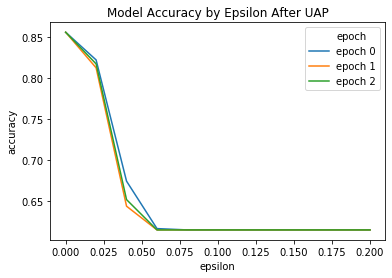

In [10]:
df_melted = df_acc.melt("epsilon", value_name="accuracy", var_name="epoch")
ax = sns.lineplot("epsilon", "accuracy", data=df_melted, markers=True, hue="epoch").set_title("Model Accuracy by Epsilon After UAP")

As shown in the graph above, the adversarial attack is indeed working in that it is able to reduce model accuracy even for relatively small values of epsilon. One notable issue though is that there is a lowerbound to how low the model accuracy can go. We investigate this further below, making use of the perturbation matrices that we have stored from the process above. First, we retrieve the perturbation for some epsilon value with an accuracy at the lowerbound, such as $\varepsilon=0.1$. 

In [11]:
#We want to get the perturbation at epoch 2 of the following epsilon value
epsilon_to_get = 0.1
#Build a DataFrame with epsilon values and indices in the perturbation matrix 
df_builder = [{"epsilon": temp["epsilon"], "index": ind} for ind,temp in enumerate(pert_matrices)] 
eps_index = pd.DataFrame(df_builder)

#Look for a particular index and retrieve the perturbation
pert_matrix_index = eps_index[eps_index["epsilon"]==epsilon_to_get].iloc[0]['index']
perturbation = pert_matrices[int(pert_matrix_index)]["epoch 2"]

Now that we have the perturbation, we can observe the prediction results, using the attack loader and model once again. This time we only store the final predictions after the perturbation. We then sum up all the predicted values and divide by the length of the number of predictions actually made (since we skip over cases where the model gets the initial prediction wrong). 

In [12]:
#Code here is very similar to the one used for UAP above 
predictions = [] 
sample_data = None
#We go through the data again using attack_loader 
for batch_idx, (data, labels) in enumerate(attack_loader):
    inputs = data.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        output = model(inputs)
        _, initial_prediction = torch.max(output.data, 1)
        #No use attacking if initial prediction was wrong
        if initial_prediction.item() != labels.item():
            continue
        perturbed_input = perturbation + inputs
        perturbed_output = model(perturbed_input)
        #We compute the prediction after perturbation 
        _,final_prediction = torch.max(perturbed_output.data, 1)
        if final_prediction.item() != labels.item():
            #We store some sample data for visualisation later 
            sample_data = {"image": inputs, "label": labels.item(), "initial_prediction": initial_prediction.item(), "final_prediction": final_prediction.item()}
        #We append the final prediction (assuming the initial prediction was correct )
        predictions.append(final_prediction.item())

#We show here that all the predictions were just 1 (PNEUMONIA) for all of the perturbed cases 
sum(predictions)/len(predictions)

1.0

We got a quotient of 1.0, meaning the model is simply predicting a class of 1 (PNEUMONIA) for all of the perturbed cases. We can infer that other values of epsilon with the same accuracy at the lowerbound exhibit the same behaviour. Thus, while UAP is able to trick the model into thinking NORMAL cases are PNEUMONIA, it is unable to do so the other way around (tricking the model to predict PNEUMONIA cases as NORMAL).

Below then we visualise a sample image where the perturbation succeeded in tricking the model into misclassification.

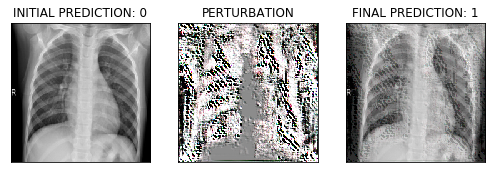

In [13]:

print()
#Converting the images into PIL format
to_img_trans = transforms.ToPILImage()
#Obtaining the original image
before=to_img_trans(sample_data["image"][0].cpu())
#Normalising the perturbation for visualisation purposes as it contains negative values.
pert=to_img_trans(normalise_image_tensor(perturbation).cpu())
#Adding the perturbation to the original image
perturbed_image = sample_data["image"][0] + perturbation
after=to_img_trans(normalise_image_tensor(perturbed_image).cpu())

fig,ax=plt.subplots(1,3)
plt.subplot(1,3,1, xticks=[], yticks=[])
plt.imshow(before)
plt.title("INITIAL PREDICTION: " + str(sample_data["initial_prediction"]))
plt.subplot(1,3,2, xticks=[], yticks=[])
plt.imshow(pert)
plt.title("PERTURBATION")
plt.subplot(1,3,3, xticks=[], yticks=[])
plt.imshow(after)
plt.title("FINAL PREDICTION: " + str(sample_data["final_prediction"]))
fig.set_size_inches(8.5,8.5)

The perturbation in this case is relatively visible as an epsilon of 0.1 was chosen, but despite mostly maintaining the look of the original from visual inspection, the model now classifies it as a case of PNEUMONIA. 

## II. Fast Gradient Sign Method
FGSM is different from UAP in that the method tailor fits a perturbation to each individual input image. While there exists numerous ways to implement this, FGSM in particular makes use of a small multiple of the sign of the gradient with respect to the input image to create this perturbation (where "small" is defined by a parameter $\varepsilon$). By perturbing data in this way, FGSM is able to push points across decision boundaries, causing them to be misclassified. The perturbed data $\tilde{x}$ can be formulated in the following way. 

$$\tilde{x}_i = x_i + \varepsilon \ sign\left(\nabla_x \mathscr{l}_i(f_w(x_i), y_i)\right)$$

We first define the fgsm_attack function below, which will be called as we iterate through the input data.

In [14]:
def fgsm_attack(image, data_gradient, epsilon=1):
    """
    Perturbs an image given an image tensor, data gradient and epsilon value
    
    Reference:
    Nathan Inkawhich. 2017. Adversarial Example Generation. https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
    
    @param 
    image: torch tensor containing the image data
    data_gradient: derivative with respect to the image input 
    epsilon: epsilon value to use for the attack 
    
    @return
    returns a perturbed image based on the sign of the data gradient 
    """
    sign = data_gradient.sign()
    perturbed_image = image + epsilon * sign
    return perturbed_image

We start by declaring the values of $\varepsilon$ to run the method for. 

In [15]:
epsilon_vals = [0,0.002,0.004,0.006,0.008,0.010,0.012,0.014,0.016,0.018,0.020]

Below then is the main implementation of the FGSM method [2]. 

In [16]:
def fgsm(epsilon_vals, attack_loader, model):
    """
    Function that runs FGSM for a given list of epsilon values on a given data loader [2].
    
    @param
    epsilon_vals: list of epsilon values to run the attack for
    attack_loader: torch DataLoader to iterate over the data set one image at a time
    model: model to be attacked by the method
    
    @return
    accuracies: list of dictionaries, each cotaining accuracy metrics for each epsilon value passed 
    perturbed_images: dictionary with epsilon values as keys and list of dictionaries 
                      (each element containing perturbed images) as values
    """
    accuracies = []
    perturbed_images = {}
    counter = 0 
    for epsilon in tqdm(epsilon_vals): 
        correct=0
        perturbed_images[epsilon] = []
        for data, labels in attack_loader: 
            data, labels = data.to(device), labels.to(device)
            #We want to get the gradient of the data as it passes through the network
            data.requires_grad=True
            outputs = model(data)
            _, initial_prediction = torch.max(outputs.data, 1)
            counter += 1
            #If the prediction was already wrong, no need to mess with it
            if initial_prediction.item() != labels.item():
                continue

            #Calculate the loss
            loss = F.nll_loss(outputs, labels)

            #Zero out gradients
            model.zero_grad()
            loss.backward()
            
            #Perform the attack using the gradient of the input data 
            data_gradient = data.grad.data 
            perturbed_data = fgsm_attack(data,data_gradient,epsilon=epsilon)
            with torch.no_grad():
                perturbed_output = model(perturbed_data)
                _,final_prediction = torch.max(perturbed_output.data, 1)
            
            #We only need sample images for visualisation later on so we store here every 10th image 
            if counter%10 == 0: 
                perturbed_images[epsilon].append({"perturbed_image": perturbed_data.detach(), 
                                                  "original_image": data.detach(),
                                                  "perturbation": data_gradient.sign() * epsilon,
                                                  "output_after": final_prediction, "output_before": labels, "correct": final_prediction.item() == labels.item()})

            #We count here the accuracy after the attack
            if final_prediction.item() == labels.item():
                correct += 1
        accuracy = correct / float(len(attack_loader))
        accuracies.append({"epsilon": epsilon, "accuracy": accuracy, "correct": correct})
    return accuracies, perturbed_images

In [17]:
accuracies, perturbed_images = fgsm(epsilon_vals, attack_loader, model)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [04:31<00:00, 24.71s/it]


We can again visualise how model accuracy decreases as the value of epsilon increases. 

Text(0.5, 1.0, 'Model Accuracy by Epsilon After FGSM')

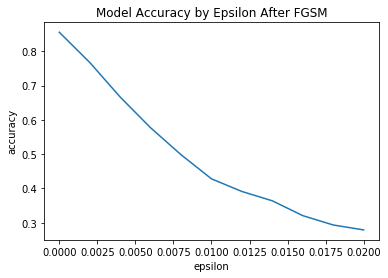

In [18]:
df_acc_fgsm = pd.DataFrame(accuracies)
sns.lineplot("epsilon", "accuracy", data = df_acc_fgsm).set_title("Model Accuracy by Epsilon After FGSM")

Clearly shown here is that applying FGSM rather drastically reduces model accuracy, even for small values of epsilon. Below is a sample image that was misclassified after the FGSM perturbation was applied with $\varepsilon=0.01$. We first retrieve some data from the perturbed_images dictionary returned by the FGSM function.

In [19]:
data_list = perturbed_images[0.01]
#We look for the first iage where the attack was a success
sample_image = None
for img in data_list:
    if not img['correct']:
        sample_image = img
        break

The code below displays a misclassified example with a seemingly imperceptible perturbation. 

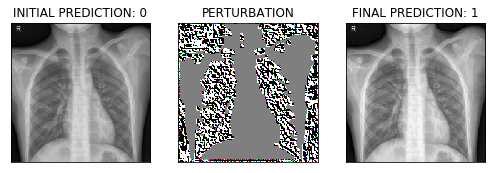

In [20]:
#Obtaining the original image
before=to_img_trans(sample_image['original_image'][0].cpu())
#Obtaining the normalised perturbation matrix
pert=to_img_trans(normalise_image_tensor(sample_image['perturbation'][0]).cpu())
#Adding the perturbation to the original image
after=to_img_trans(normalise_image_tensor(sample_image['perturbed_image'][0]).cpu())

fig,ax=plt.subplots(1,3)
plt.subplot(1,3,1,xticks=[],yticks=[])
plt.imshow(before)
plt.title("INITIAL PREDICTION: " + str(sample_image["output_before"].item()))
plt.subplot(1,3,2,xticks=[],yticks=[])
plt.imshow(pert)
plt.title("PERTURBATION")
plt.subplot(1,3,3,xticks=[],yticks=[])
plt.imshow(after)
plt.title("FINAL PREDICTION: " + str(sample_image["output_after"].item()))
fig.set_size_inches(8.5,8.5)

## III. Comparison of Results 

In this section, we then compare the impact these adversarial attacks have on model accuracy. To allow this comparison, we run UAP again, this time with the same epsilon values that we used for FGSM (which are smaller than the initial set we used previously). 

In [21]:
epsilon_vals = [0,0.002,0.004,0.006,0.008,0.010,0.012,0.014,0.016,0.018,0.020]
accuracies, pert_matrices = universal_adversarial_perturbation(lr, epochs, epsilon_vals, xi_size, data_loader, attack_loader, model)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [12:38<00:00, 68.98s/it]


We then visualise below the effects of the two attacks on model accuracy for the same values of epsilon.

Text(0.5, 1.0, 'Comparison of Model Accuracy After UAP and FGSM')

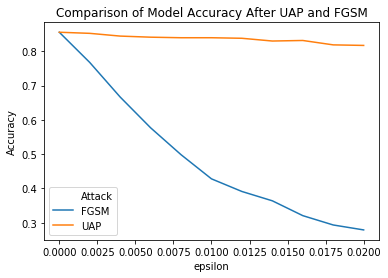

In [22]:
df_acc_uap = pd.DataFrame(accuracies)
df_acc_uap = df_acc_uap[["epsilon", "epoch 2"]]
df_acc_uap = df_acc_uap.rename({"epoch 2": "UAP"},axis=1)
df_acc_fgsm = df_acc_fgsm.rename({"accuracy": "FGSM"}, axis=1)
merged_results = df_acc_fgsm.merge(df_acc_uap,on="epsilon", how="left").drop(["correct"],axis=1)
melted = merged_results.melt("epsilon", var_name="Attack", value_name="Accuracy")
plot = sns.lineplot("epsilon", "Accuracy", data=melted, hue="Attack")
plot.set_title("Comparison of Model Accuracy After UAP and FGSM")

We can see from the visual above that FGSM was a much more effective attack, especially for small values of epsilon where UAP was not able to significantly affect model accuracy. Aside from this, there was no longer a lowerbound of around $60\%$  to model accuracy after applying FGSM. This means the method is capable of targetting both NORMAL and PNEUMONIA cases for misclassification unlike UAP, which failed to convert PNEUMONIA cases to NORMAL. Because of this, one might say that FGSM is the better attack methodology when it comes to maximising damage on a model in this particular context. 

# IV. Conclusion & Further Study
We can conclude that for this specific case, FGSM is much more effective at reducing the classification power of the model, especially for small values of epsilon. Universal Adversarial perturbation was still able to reduce model accuracy, but it hit a lowerbound of around $60\%$ and required larger values of epsilon to significantly impact model performance, which produced much more perceptible perturbations.

Given more time, there are still possible extensions to this study on adversarial attacks. One possibility would be improvements in the optimisation of the UAP by testing further with a variety of learning rates, more epochs, or implementation of momentum. All this could potentially produce better results, even for the small values of epsilon it struggled with. Another possibility would have been to implement adversarial learning by training on a small fraction of perturbed images (either through UAP or FGSM) and testing whether this would make the model more resilient to attack. 

# V. References
[1] Paul Mooney. 2018. Chest X-Ray Images (Pneumonia). https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia.  
[2] Nathan Inkawhich. 2017. Adversarial Example Generation. https://pytorch.org/tutorials/beginner/fgsm_tutorial.html.  